# Project 3: Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

## Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
repo_path = !pwd  # repo path
env_path  = repo_path[0] + '/env/Tennis_Linux/Tennis.x86_64'
env = UnityEnvironment(file_name= env_path)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## Examine the State and Action Spaces
In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


## Hyperparameters

In [5]:
import numpy as np
import random
import copy
from collections import namedtuple, deque
import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE  = int(1e4)  # replay buffer size
BATCH_SIZE   = 128 * 2   # minibatch size
GAMMA        = 1.0       # discount factor
TAU          = 1e-3      # for soft update of target parameters
LR_ACTOR     = 1e-4      # learning rate of the actor 
LR_CRITIC    = 1e-3      # learning rate of the critic
WEIGHT_DECAY = 0         # L2 weight decay

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
print(device)

cpu


## Define the Actor/Critic nn models(pytorch)

In [6]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, input_size, output_size, seed, fc1_units=256, fc2_units=256):
        """Initialize parameters and build actor model.
            input_size  (int): input layer size
            output_size (int): output layer size
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(input_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, output_size)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        if state.dim() == 1:
            state = torch.unsqueeze(state,0)
        x = F.relu(self.fc1(state))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, input_size, seed, fc1_units=256, fc2_units=256):
        """Initialize parameters and build model.
            input_size  (int): input layer size
            output_size: is equal to 1
            seed (int): Random seed
            fc1_units : Number of nodes in the first hidden layer
            fc2_units : Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(input_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, states, actions):
        """Build a critic network that maps (states, actions) pairs -> Q-values."""
        xs = torch.cat((states, actions), dim=1)
        x = F.relu(self.fc1(xs))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

## Replay Memory Class and Methods
Replay memory implementation with minimal change to the original Q-learning example that is provided in the class.

In [7]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        random.seed(seed)
        np.random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Ornstein-Uhlenbeck noise generation

In [8]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.size = size
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        random.seed(seed)
        np.random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.size)
        self.state = x + dx
        return self.state

## DDPG Agent 

There will be two agents of this type that will be learning in the environment, each with their own local and target, Actor/Critic networks.

In [9]:
class ddpg():
    """DDPG agent modified for MADDPG."""

    def __init__(self, agent_id, action_size=2, seed=0):
        """Initialize an Agent object.
        
        Params
        ======
            agent_id: agent id in a multi-agent environment
            action_size : dimension of each action
            seed : Random seed
            tau : for soft update of target parameters
        """
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.id = agent_id
        self.tau = TAU
      
        # Actor Network (w/ Target Network)
        self.actor_local  = Actor(state_size, action_size, seed).to(device)
        self.actor_target = Actor(state_size, action_size, seed).to(device)
        self.copy_network_parms(self.actor_local, self.actor_target)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)
        
        # Critic Network (w/ Target Network)
        critic_input_size = (state_size+action_size)*num_agents
        self.critic_local  = Critic(critic_input_size, seed).to(device)
        self.critic_target = Critic(critic_input_size, seed).to(device)
        self.copy_network_parms(self.critic_local, self.critic_target)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, seed)

  
    def act(self, state, noise_level=1.0, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            self.noise_val = self.noise.sample() * noise_level
            action += self.noise_val
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, agent_id, all_next_actions, all_actions, gamma, experiences):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            agent_id: unique id for each agent
            all_next_actions : each agents' next_action
            all_actions  : agents' actions
            gamma (float): discount factor
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        self.critic_optimizer.zero_grad()
        agent_id = torch.tensor([agent_id]).to(device)
        actions_next = torch.cat(all_next_actions, dim=1).to(device)
        with torch.no_grad():
            Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_expected = self.critic_local(states, actions)
        # Q_targets = r + discount * Q(st+1,at+1)_target
        Q_targets = rewards.index_select(1, agent_id) + (gamma * Q_targets_next * (1 - dones.index_select(1, agent_id)))
        # Compute critic loss
        critic_loss = F.mse_loss(Q_expected, Q_targets.detach())
        # Minimize the loss
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        # find each agent's actions based on their ids
        actions_pred = [actions if i == self.id else actions.detach() for i, actions in enumerate(all_actions)]
        actions_pred = torch.cat(actions_pred, dim=1).to(device)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.update(self.critic_local, self.critic_target, self.tau)
        self.update(self.actor_local, self.actor_target, self.tau)
        self.noise.reset()


    def update(self, local_model, target_model, tau):
        """update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def copy_network_parms(self, local, target):
        for target_param, local_param in zip(target.parameters(), local.parameters()):
            target_param.data.copy_(local_param.data)


## Multi Agent DDPG Class
This is the main agent that will be interacted with during the training. It has a joint replay memory and is responsible for calling individual agents learning methods, once enough experiences is gathered from the environment at the correct intervals.

In [10]:
class multi_agent_ddpg():
    """Multi agent class that contains takes arbitrary 
       (two by default) DDPG agents and a shared replay 
       buffer.
    """

    def __init__(self, action_size=2, random_seed=0, num_agents=2, update_freq=2, 
                 init_noise_level=1.0, noise_decay=1.0, noise_termination_step=3e4):
        
        """
            action_size : number of actions
            random_seed : random stream generator
            num_agents  : number of agents in the scene
            gamma : discount factor
            init_noise_level : initial noise level
            noise_decay : noise decay rate
            update_freq : interval for updating the network
            noise_termination_step : max number of timesteps with noise applied in training
        """

        self.step_cnt     = 0
        self.batch_size   = BATCH_SIZE
        self.update_freq  = update_freq
        self.gamma        = GAMMA
        self.num_agents   = num_agents
        self.noise_on     = True
        self.noise_level = init_noise_level
        self.noise_decay  = noise_decay
        self.noise_termination_step = noise_termination_step

        # create 2 agents that have their own actor/critic networks
        self.agents = [ddpg(i) for i in range(num_agents)]
        # create joint replay buffer
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, self.batch_size, random_seed)

    def act(self, all_states, add_noise=True):
        """finds the actions of all agents in the env"""
        all_actions = []
        for agent, state in zip(self.agents, all_states):
            action = agent.act(state, noise_level=self.noise_level, add_noise=self.noise_on)
            self.noise_level *= self.noise_decay
            all_actions.append(action)
        return np.array(all_actions).reshape(1, -1)

    def step(self, all_states, all_actions, all_rewards, all_next_states, all_dones):
        # Enables turning off the OUNoise as the agents become mature
        if self.step_cnt > self.noise_termination_step:
            self.noise_on = False

        all_states = all_states.reshape(1, -1)            # falttening to store in the joint memory
        all_next_states = all_next_states.reshape(1, -1)  # falttening to store in the joint memory
        self.memory.add(all_states, all_actions, all_rewards, all_next_states, all_dones)
        
       
        self.step_cnt = self.step_cnt + 1     
        # wait for all agents before learning
        if self.step_cnt % self.update_freq == 0:
            # Fill up the batch before learning
            if len(self.memory) > self.batch_size:
                # draw random experiences from the joint memory and learn
                experiences = [self.memory.sample() for _ in range(self.num_agents)]
                self.learn(experiences, self.gamma)


    def learn(self, experiences, gamma):
        """ Calculating next actions based on actor of each agent"""
        all_next_actions = []
        all_actions = []
        for i, agent in enumerate(self.agents):
            states, _, _, next_states, _ = experiences[i]
            agent_id = torch.tensor([i]).to(device)
            # find the current state for each agent
            state = states.reshape(-1, 2, 24).index_select(1, agent_id).squeeze(1)
            action = agent.actor_local(state)
            all_actions.append(action)
            # find the next state for each agent
            next_state = next_states.reshape(-1, 2, 24).index_select(1, agent_id).squeeze(1)
            next_action = agent.actor_target(next_state)
            all_next_actions.append(next_action)
                       
        # Learning by random sampling
        for i, agent in enumerate(self.agents):
            agent.learn(i, all_next_actions, all_actions, gamma, experiences[i])
            
    def save_agents(self):
        # save local actor and critic networks
        for i, agent in enumerate(self.agents):
            torch.save(agent.actor_local.state_dict(),  "actor_agent_{}.pth".format(i))
            torch.save(agent.critic_local.state_dict(), "critic_agent_{}.pth".format(i))

## Tennis Player Class
The main wrapper class for training or scoring a trained tennis player agents.

In [17]:
class tennis_player_maddpg:
    def __init__(self, env, score_mode=False, seed_in=0, init_noise_level=0.5, update_freq=2, noise_termination_step=3e4):
        self.env   = env
        self.agents = multi_agent_ddpg(random_seed=seed_in, init_noise_level=0.5, update_freq=2, noise_termination_step=3e4)
        self.dump_freq   = 100
        self.score_mode  = score_mode


    def train(self, n_episodes=8000, n_actions=1000, target_score=0.5):
        scores_deque = deque(maxlen=self.dump_freq)
        scores_global = []
        scores = []
        scores_avg = []
       
        for i_episode in range(1, n_episodes + 1):           
            env_info = self.env.reset(train_mode=True)[brain_name]
            states = env_info.vector_observations
            rewards = []

            for t in range(n_actions):
                actions = self.agents.act(states)
                env_info = self.env.step(actions)[brain_name]  # step the env
                next_states = env_info.vector_observations     # get the next states (multiple agents allowed)
                agent_rewards = env_info.rewards               # collect the rewards (multiple agents allowed)
                dones = env_info.local_done                    # check if episode finished
                self.agents.step(states, actions, agent_rewards, next_states, dones)
                states = next_states
                rewards.append(agent_rewards)
                if np.any(dones):
                    break
            
            episode_reward = np.max(np.sum(np.array(rewards),axis=0))

            scores.append(episode_reward)             # update the score history
            scores_deque.append(episode_reward)       # update the running deque (last 100)
            deque_avg_score = np.mean(scores_deque)   # update the average score for running deque (last 100)
            scores_avg.append(deque_avg_score)      
            scores_global.append(np.sum(np.array(rewards),axis=0))

            print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, deque_avg_score),end="")

            # save the agents at the end of each deque
            if i_episode % self.dump_freq == 0:
                print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, deque_avg_score))
                self.agents.save_agents()

            # Exit if solved
            if deque_avg_score>=target_score:
                print('\nReached the target score {} in {} episodes.\tAverage Score: {:.3f}'.format(target_score, i_episode, deque_avg_score))
                self.agents.save_agents()
                break        

        return scores, scores_global

    def play(self, n_episodes=3, n_actions=200, load=False):
            if load:
                for i, agent in enumerate(self.agents.agents):
                    self.agents.agents[i].actor_local.load_state_dict(torch.load("actor_agent_{}.pth".format(i)))
                    self.agents.agents[i].critic_local.load_state_dict(torch.load("critic_agent_{}.pth".format(i)))

            scores_deque = deque(maxlen=self.dump_freq)
            scores = []
            scores_avg = []
            
            for i in range(n_episodes):
                env_info = self.env.reset(train_mode=True)[brain_name]
                states = env_info.vector_observations
                rewards = []
                num_agents = len(env_info.agents)
                for j in range(n_actions):

                    actions = self.agents.act(states)
                    env_info = self.env.step(actions)[brain_name]  # step the env
                    next_states = env_info.vector_observations     # get the next states (multiple agents allowed)
                    agent_rewards = env_info.rewards               # collect the rewards (multiple agents allowed)
                    dones = env_info.local_done                    # check if episode finished
                    self.agents.step(states, actions, agent_rewards, next_states, dones)
                    states = next_states
                    rewards.append(agent_rewards)
                    if np.any(dones):
                        break

                episode_reward = np.max(np.sum(np.array(rewards),axis=0))

                scores.append(episode_reward)             # update the score history
                scores_deque.append(episode_reward)       # update the running deque (last 100)
                deque_avg_score = np.mean(scores_deque)   # update the average score for running deque (last 100)
                scores_avg.append(deque_avg_score)      
                if np.any(dones):                    
                    break

## Train and Serialize the Trained Agents

In [12]:
tennis_player  = tennis_player_maddpg(env, seed_in=2, init_noise_level=0.5, noise_termination_step=3e4)
scores, scores_all = tennis_player.train(n_episodes=8000, n_actions=1000, target_score=0.5)
np.save('scores.npy', scores, scores_all)

Episode 100	Average Score: 0.004
Episode 200	Average Score: 0.005
Episode 300	Average Score: 0.016
Episode 400	Average Score: 0.034
Episode 500	Average Score: 0.019
Episode 600	Average Score: 0.027
Episode 700	Average Score: 0.006
Episode 800	Average Score: 0.010
Episode 900	Average Score: 0.040
Episode 1000	Average Score: 0.057
Episode 1100	Average Score: 0.101
Episode 1200	Average Score: 0.147
Episode 1300	Average Score: 0.099
Episode 1400	Average Score: 0.132
Episode 1500	Average Score: 0.196
Episode 1600	Average Score: 0.136
Episode 1700	Average Score: 0.163
Episode 1781	Average Score: 0.513
Reached the target score 0.5 in 1781 episodes.	Average Score: 0.513


## Training performance
Visualizing the training progress with superimposed moving average.

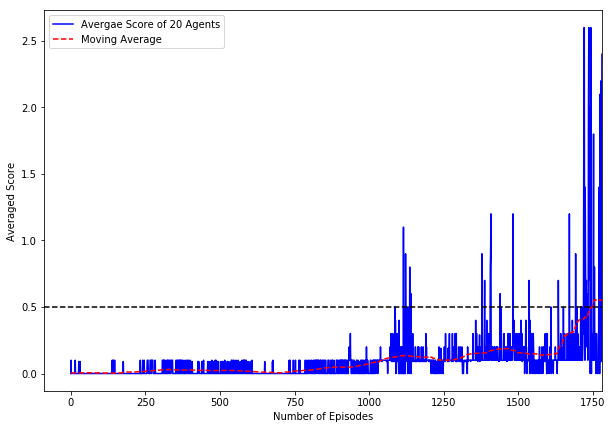

In [20]:
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter1d

scores = np.load('scores.npy')
n = len(scores)
mean_scores  = [np.mean(scores[i]) for i in np.arange(n)]

# Draw the line plot
plt.figure(figsize=(10,7))
plt.plot(np.arange(n), mean_scores, color='b')

# Draw the moving average
win_len = int(n/10)
mv_avg = uniform_filter1d(mean_scores, size=win_len)
plt.plot(mv_avg,'-r',linestyle='--');
plt.axhline(y=0.5, color='k', linestyle='dashed')
plt.legend(["Avergae Score of 20 Agents", "Moving Average"])

# Define the label of the plots
plt.xlabel('Number of Episodes')
plt.ylabel('Averaged Score')
plt.xlim(right=n)

     
# Display the plot
plt.show()

## Watch the agents play

In [18]:
env.reset()
tennis_player  = tennis_player_maddpg(env, seed_in=2, score_mode=True)
env.train_mode = False
scores = tennis_player.play(n_episodes=5, n_actions=1000, load=True)

In [19]:
env.close()